# 在MNIST数据集上用经典GAN完成图像生成

经典GAN结构如下：
![image.png](imgs/1.png)

参考自https://zhuanlan.zhihu.com/p/72279816

对于MNIST数据集，其包含60,000张用于训练的图像和10,000张用于测试的图像，图像大小固定为28x28像素。

该数据集的官方地址为：http://yann.lecun.com/exdb/mnist/

项目参考：https://aistudio.baidu.com/aistudio/projectdetail/2055395?channelType=0&channel=0

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import sys
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 数据准备
通过 SSH 客户端或 JupyterLab 进入实例终端，在 /hy-public 文件夹内可以找到公共数据集。使用数据集时先将数据集复制到 hy-tmp 或 /hy-nas(仅包含共享存储机型)内，再进行解压。
```
mkdir -p ~/Datasets/MNIST/MNIST/raw
cp /hy-public/MNIST/* ~/Datasets/MNIST/MNIST/raw
```


In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

mnist_train = torchvision.datasets.MNIST(root='~/Datasets/MNIST', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='~/Datasets/MNIST', train=False, download=True, transform=transform)

print(len(mnist_train), len(mnist_test))

60000 10000


## 数据探查

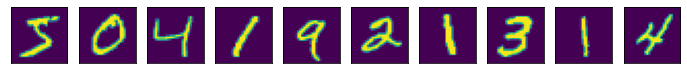

In [3]:
def show_fashion_mnist(images):
    '''
    显示图片
    :param images: 图片数据，list(torch.Size([1, 28, 28]))
    '''
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img in zip(figs, images):
        f.imshow(img.view((28, 28)).numpy())
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
# 取前10张图像可视化
X = []
for i in range(10):
    X.append(mnist_train[i][0])
show_fashion_mnist(X)


## GAN网络搭建
整体网络结构包括一个生成器和一个判别器，简单来说，就是让两个网络相互竞争，生成网络来生成假的数据，对抗网络通过判别器去判别真伪。

### 判别器网络结构定义
判别器的作用主要是用来完成真假图片的判别，当输入一张真实的图片时，希望判别器输出的结果是1，当输入一张生成器伪造的图片时，希望判别器输出的结果是0。

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.D(x)
        return x

### 生成器网络结构定义
生成器的目的主要是生成以假乱真的图片，接着我们要看看如何生成一张假的图片。首先给出一个简单的高维的正态分布的噪声向量，接着通过一些全连接、卷积、池化、激活函数等操作，最后得到一个与输入图片大小一样的噪声图片，也就是假图像。

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.G = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.G(x)
        return x

## 定义模型训练函数


In [6]:
def train_gan(data_iter, netD, netG, optimizerD, optimizerG, loss, device, num_epochs, batch_size):
    '''
    GAN模型训练函数
    
    :param data_iter: 数据迭代器，torch.utils.data.DataLoader
    :param netD: 判别网络
    :param netG: 生成网络
    :param optimizerD: 判别网络优化器
    :param optimizerG: 生成网络优化器
    :param loss: 损失函数
    :param device: 执行设备：cpu & gpu，
    :param num_epochs: 迭代次数
    :param batch_size: 批量大小
    '''
    result_batch_epoch = [[],[],[]]  # 存储每个batch的结果
    result_each_epoch = [[],[],[]]  # 存储每个epoch的结果
    K = 1

    for epoch in range(num_epochs):
        for batch_idx, (data, label) in enumerate(data_iter):
            netD.to(device)
            netG.to(device)
            real_images = data.to(device).reshape((batch_size, 1, 28*28))

            #训练判别器 
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            optimizerD.zero_grad()
            # 判别真实数据，并计算损失，目的是让判别器尽量识别出真实数据
            d_real_predict = netD(real_images)
            d_real_loss = loss(d_real_predict, torch.ones_like(d_real_predict))

            # 判别生成器生成的数据，并计算损失，目的是让判别器尽量识别出生成器伪造的数据
            noise = torch.randn([BATCH_SIZE, 100]).to(device) # 使用正态分布噪音作为假的图片
            fake_images = netG(noise)
            d_fake_predict = netD(fake_images)
            d_fake_loss = loss(d_fake_predict, torch.zeros_like(d_fake_predict))

            # 训练判别器
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizerD.step()

            result_batch_epoch[0].append(d_loss.cpu().detach().numpy())

            ###训练生成器
            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            # 生成器生成假的图片送入判别器，并计算损失，目的是让判别器分不开真假数据。
            for _ in range(K):
                optimizerG.zero_grad()
                noise = torch.randn([BATCH_SIZE, 100]).to(device)
                fake_images = netG(noise)
                g_fake_predict = netD(fake_images)
                g_loss = loss(g_fake_predict, torch.ones_like(g_fake_predict))

                # 训练生成器
                g_loss.backward()
                optimizerG.step()

            result_batch_epoch[1].append(g_loss.cpu().detach().numpy())

            fake_score = torch.sum(g_fake_predict).cpu().detach().numpy() / BATCH_SIZE
            result_batch_epoch[2].append(fake_score)
            
            if d_loss.cpu().detach().numpy() < g_loss.cpu().detach().numpy():
                K = int((g_loss.cpu().detach().numpy() - d_loss.cpu().detach().numpy()) * 4) + 1
            else:
                K = 1

        result_each_epoch[0].append(d_loss.cpu().detach().numpy())
        result_each_epoch[1].append(g_loss.cpu().detach().numpy())
        result_each_epoch[2].append(fake_score)
        print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.cpu().detach().numpy()}, Loss G: {g_loss.cpu().detach().numpy()}, Fake Score: {fake_score}, K: {K}')
    return result_batch_epoch, result_each_epoch

In [7]:
# 生成网络结构实例
generator = Generator()
discriminator = Discriminator()

# 超参数
BATCH_SIZE = 256
EPOCHS = 50

# 优化器
optimizerG = torch.optim.Adam(lr=0.001, params=generator.parameters(), betas=(0.5, 0.999))

optimizerD = torch.optim.Adam(lr=0.001, params=discriminator.parameters(), betas=(0.5, 0.999))
    
# 损失函数
loss = nn.BCELoss()

data_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

result_batch_epoch, result_each_epoch = train_gan(data_loader, discriminator, generator, optimizerD, optimizerG,
                                                  loss, device, num_epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch [1/50] Loss D: 1.1304550170898438, Loss G: 2.32936692237854, Fake Score: 0.10076947510242462, K: 5
Epoch [2/50] Loss D: 1.0691075325012207, Loss G: 1.2726585865020752, Fake Score: 0.28182080388069153, K: 1
Epoch [3/50] Loss D: 1.1488938331604004, Loss G: 1.1552209854125977, Fake Score: 0.3163626194000244, K: 1
Epoch [4/50] Loss D: 1.1851279735565186, Loss G: 1.0759553909301758, Fake Score: 0.34967777132987976, K: 1
Epoch [5/50] Loss D: 1.2816603183746338, Loss G: 1.4499871730804443, Fake Score: 0.2521933615207672, K: 1
Epoch [6/50] Loss D: 1.8366210460662842, Loss G: 1.1210181713104248, Fake Score: 0.3366025686264038, K: 1
Epoch [7/50] Loss D: 1.4519312381744385, Loss G: 1.3331561088562012, Fake Score: 0.2755647897720337, K: 1
Epoch [8/50] Loss D: 1.1693744659423828, Loss G: 1.4371347427368164, Fake Score: 0.25563839077949524, K: 2
Epoch [9/50] Loss D: 1.1553623676300049, Loss G: 1.3493874073028564, Fake Score: 0.28083354234695435, K: 1
Epoch [10/50] Loss D: 1.2710120677947998, L

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: object of type 'NoneType' has no len()

In [ ]:
plt.figure(figsize=(12, 6))
x = np.arange(len(result_each_epoch[0]))
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Number of Batch')
plt.plot(x,np.array(result_each_epoch[0]),label='D Loss')
plt.plot(x,np.array(result_each_epoch[1]),label='G Loss')
plt.plot(x,np.array(result_each_epoch[2]),label='Fake Score')
plt.legend()
# plt.savefig('work/Generator and Discriminator Loss During Training.png')
plt.show()

In [ ]:
# 训练完成后，需要验证GAN模型的效果，此时，自定义10张噪声数据，然后用训练好的模型对测试数据进行预测。

noise = torch.randn([10, 100]).to(device)

fake_images = generator(noise)
X = []
for i in range(10):
    img = fake_images[i].reshape((-1, 28, 28)).cpu().detach()
    X.append(img)

show_fashion_mnist(X)